# ΓΙΝΕΤΑΙ ΧΡΗΣΗ FREE PASS ΚΑΙ ΟΧΙ ΠΟΛΙΤΙΚΗ ΓΙΑ ΚΑΘΥΣΤΕΡΗΜΕΝΕΣ ΑΣΚΗΣΕΙΣ.

# ΑΣΚΗΣΗ 2
Βασίλης Πουλος, 2805  
Κωστάκης Ελευθέριος-Παναγιώτης, 2741

# Step 1

In [1]:
import pandas as pd
import numpy as np
import json
import time

leftK_path = '/home/left/Desktop/dataMining/set2/ask2/'

filename = 'yelp_academic_dataset_business.json'


start = time.time()
# Store all businesses
data = [json.loads(line) for line in 
        open(leftK_path + filename, 'r', encoding="utf8")]

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 0.059 mins


In [2]:
# Keep businesses which are located in Toronto
data = [x for x in data if x['city']=='Toronto']
data = np.array(data) # Convert list to numpy array

# Create an array with Toronto located businesses with more than 15 reviews
business_col = np.array([])
for i in range(len(data)):
    if data[i]['review_count']>=15:
        business_col = np.append(business_col,data[i]['business_id'])

In [3]:
# Helping function to check if a business is in business_col (Toronto and >=15 reviews)
def get_business_index(business_id):
    return np.where(business_col == business_id)[0]

In [4]:
filename = 'yelp_academic_dataset_review.json'
start = time.time()

user_business = []
# Read the json review file line by line and keep the reviews referring to business_col 
with open(leftK_path + filename,'r',encoding="utf8") as reviews_file:

    for line in reviews_file:
        line = json.loads(line)
        ind = get_business_index(line['business_id'])

        if ind.size>0:
            user_business.append([line['user_id'],line['business_id'], line['stars']])
            
stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 9.845 mins


In [5]:
# User business have all the reviews we want. But using numpy unique will keep the first occurency.
# We want to keep last occurency, so a smart way to do so is to read our list with all pairs of 
# type (UserID, BusinessID, Rating) upside-down(reverse). Then call unique and reconstruct the 
# total reviews with the give indices.
user_business.reverse()
from operator import itemgetter
user_bus_sorted = sorted(user_business, key=itemgetter(0,1))

user_bus_sorted = np.array(user_bus_sorted)
pairs = user_bus_sorted[:,0:2]
_, idx = np.unique(pairs, axis=0, return_index=True)
total_reviews = user_bus_sorted[idx]

In [6]:
# Take the userID column and keep the unique users. Do a for-loop to keep users with >=15 reviews.
users = total_reviews[:,0]
unique_users, counts = np.unique(users, return_counts=True)
uniq_users = []

for i in range(len(unique_users)):
    if counts[i]>=15:
        uniq_users.append(unique_users[i])
uniq_users = np.array(uniq_users)

# Here keep the unique businesses column
businesses = total_reviews[:,1]
unique_businesses = np.unique(businesses)

start = time.time()
# Create the sparse_array using the unique users(rows) and unique businesses (columns)
sparse = np.zeros((len(unique_businesses), len(uniq_users)))
for i in range(len(unique_businesses)):
    user_index = np.where(unique_businesses[i] == total_reviews)[0]

    for j in range(len(user_index)):
        unique_user_ind = np.where(total_reviews[user_index[j]][0] == uniq_users) 
        if unique_user_ind[0].size>0:
            sparse[i][unique_user_ind[0][0]] = int(float(total_reviews[user_index[j]][2]))
            
stop = time.time()
print("Sparse array created in {:.3f} mins".format((stop-start)/60))

# Sparse array shape indicates the initial unique users and unqiue businesses
sparse.shape

Sparse array created in 2.962 mins


(7602, 5677)

In [8]:
# Prune until nothing to delete

stop=0
while(stop==0):
    # prune the rows(businesses with below 15 reviews)
    index_to_delete = []
    for i in range(sparse.shape[0]):
        nonzero_indexes = np.nonzero(sparse[i])
        if len(nonzero_indexes[0])<15:
            index_to_delete.append(i)
            
    #make new sparse array with deleted items and unique_businesses to track ids
    unique_businesses = np.delete(unique_businesses, index_to_delete)
    sparse = np.delete(sparse, index_to_delete, axis=0)
    
    #prune the columns(users)
    transposed_sparse = np.transpose(sparse)
    columns_to_delete = []
    for i in range(transposed_sparse.shape[0]):
        nonzero_values = np.nonzero(transposed_sparse[i])
        if len(nonzero_values[0])<15:
            columns_to_delete.append(i)
            
    #make new sparse array with deleted items and uniq_users to track ids
    uniq_users = np.delete(uniq_users, columns_to_delete)
    sparse = np.delete(sparse, columns_to_delete, axis=1)
    
    # If nothing to delete -> stop
    if len(index_to_delete)==0 and len(columns_to_delete)==0:
        stop=1

# After pruning we have our sparse array reshaped
sparse.shape

(4092, 4794)

In [9]:
# Create the new data, create a list([userID,businessID,rating]) using our sparse array data
data_csv = []
start = time.time()
for i in range(sparse.shape[1]):
    for j in range(sparse.shape[0]):
        if sparse[j][i]>0:
            data_csv.append([uniq_users[i],unique_businesses[j], sparse[j][i]])
stop = time.time()
print("Data list created in {:.3f} mins".format((stop-start)/60))

Data list created in 0.202 mins


In [10]:
# Load the target file -- we want our data_csv to be exactly the same with pruned_data.csv
table_R = pd.read_csv("pruned_data.csv", header = None)
table_list = table_R.values.tolist()

In [11]:
# To check if our data are the same we need to sort both with the same way(here by (userID,businessID) )
from operator import itemgetter
data_csv = sorted(data_csv, key=itemgetter(0,1), reverse=True)
table_R = sorted(table_list, key=itemgetter(0,1), reverse=True)

In [12]:
# Convert our lists to numpy array to check if they are exactly the same using array_equal()
table_R = np.array(table_R)
data_csv = np.array(data_csv)
np.array_equal(table_R,data_csv)

True

# Step 2

In [13]:
import pandas as pd 
import math
import numpy as np
import json

# We have the file ready from Step 1
data_table = pd.DataFrame(data_csv, columns = ['user_id', 'business_id', 'rating'])
print(data_table)

                       user_id             business_id rating
0       zzmhLxcZ4XZQyz95c_KbOA  zFR99jgMi-qzaJXIx8MXHA    4.0
1       zzmhLxcZ4XZQyz95c_KbOA  ynmTXY9yJDiNkO4HUmxRSQ    4.0
2       zzmhLxcZ4XZQyz95c_KbOA  v_UM-AW9YYTCbWUNa-w1Gg    5.0
3       zzmhLxcZ4XZQyz95c_KbOA  swM_9CXxkvxEk3fDkjA6PQ    4.0
4       zzmhLxcZ4XZQyz95c_KbOA  nktQ_aBRp5CmVOkXR0Mz1g    5.0
...                        ...                     ...    ...
197107  --BumyUHiO_7YsHurb9Hkw  5DDvJhkk3zsd9jBxDQpkow    4.0
197108  --BumyUHiO_7YsHurb9Hkw  4SyAKQevPuB4punANp41-Q    4.0
197109  --BumyUHiO_7YsHurb9Hkw  41o1FUbCYKJv2djtnlkzlg    3.0
197110  --BumyUHiO_7YsHurb9Hkw  1W_gZM_uuEvJqapbIl6z9Q    5.0
197111  --BumyUHiO_7YsHurb9Hkw  -b94nkPVLQw95zgtDhcpYA    1.0

[197112 rows x 3 columns]


In [14]:
print("Sample data should have {} rows \n".format(math.ceil(len(table_R)*0.05)))
sample_data = data_table.sample(frac=0.05)
print(len(sample_data))

Sample data should have 9856 rows 

9856


In [15]:
# Setting sample ratings to zero
for index in sample_data.index:
    data_table.at[index, 'rating'] = 0

In [16]:
# Create the numpy array, unique_users and unique_business lists
data_table_R = data_table.to_numpy()
unique_users = np.unique(data_table_R[:,0])
unique_business = np.unique(data_table_R[:,1])

#### The main idea here is to create the sparse_array row by row using and unique_business as indices. What we do is to take for every unique user all the businesses that there are ratings. So let's say we have the userID 'iamuserid1' in row 0 in unique_users, then we get all business IDS that that user has a rating. Finally we have all businessIDS indices, for example let's say 'iamuserid1' has ratings for businesses which are located in index 2,55,123,222 in unique_business array. We will use these values as our columns indices in the sparse_array, so we have to assign ratings at sparse(0,2), sparse(0,55), sparse(0,123), sparse(0,222) .. etc. for every user.  

In [17]:
start = time.time()

sparse_array = np.zeros((len(unique_users), len(unique_business)))
# Create the sparse_array
for i in range(len(unique_users)):
    # Take all business index that a user has a rating
    business_index = np.where( unique_users[i] == data_table['user_id']) 
    
    # For all the businesses indexes find its index in unique_business and assign that index value
    # in the sparse array too.
    for j in range(len(business_index[0])):
        temp_business = data_table['business_id'][business_index[0][j]] #take business_id for given index
        unique_business_ind = np.where(temp_business == unique_business)
        sparse_array[i][unique_business_ind[0][0]] = data_table['rating'][business_index[0][j]]

stop = time.time()
print("Sparse array created in {:.3f} mins".format((stop-start)/60))

Sparse array created in 2.199 mins


# Βημα 3

### Get user similarities table

In [18]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(sparse_array)
sample_array = sample_data.to_numpy()

### This is helping functions to get user_id or business_id index in unique_users/business array

In [19]:
def find_index(user_id):
    ind = np.where(user_id  == unique_users)
    return ind[0][0]
def find_business(business_id):
    ind = np.where(business_id == unique_business)
    return ind[0][0]

### UCF prediction function

In [20]:
def UCF_prediction(user1, common_users, ratings, k_values):
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        similar.append([common_users[i], float(similarities[user_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our user
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute UCF_prediction for every given k

In [21]:
predictions = []
business_avg_pred = []
k_values = [1,5,10,20,50,100,200,500,1000]

start = time.time()
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_users = [] # USER_IDS THAT ALSO RATED THE GIVEN BUSINESS
    common_ratings = [] # AND THEIR RATINGS
    business_index = find_business(sample_array[i][1]) # Get business index
    common_users_indexes = np.nonzero(sparse_array[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
    for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
        common_ratings.append(sparse_array[common_users_indexes[0][j]][business_index]) # Append ratings
        common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id

    # Append the prediction
    predictions.append(UCF_prediction(sample_array[i][0], common_users, common_ratings, k_values))
    business_avg_pred.append(sum(common_ratings)/len(common_ratings))

ucf_predictions = np.array(predictions)

stop = time.time()
print("UCF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

UCF predictions for all given k values in 2.539 mins


# Βημα 4

### Transposed sparse array and similarities for businesses

In [22]:
# Get transposed sparse array and similiarities between businesses
transposed_sparse = np.transpose(sparse_array)
business_similarities = cosine_similarity(transposed_sparse)

### ICF prediction function

In [23]:
def ICF_prediction(business1, common_businesses, ratings, k_values):
    business_ind1 = find_business(business1)
    similar = []
    predictions_k = []
    
    # For every common business find its' similarity to our business
    for i in range(len(common_businesses)):
        temp_ind = find_business(common_businesses[i])
        similar.append([common_businesses[i], float(business_similarities[business_ind1][temp_ind]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our business
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute ICF_prediction for every given k

In [24]:
predictions = []
user_avg_pred = []
k_values = [1,5,10,20,40,50,60,70,80,100]

start = time.time()
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_ratings = [] # RATINGS OF ALL BUSINESS BY USER
    common_businesses = [] # ALL BUSINESSES THE GIVEN USER HAS RATED
    user_index = find_index(sample_array[i][0]) # Get user index
    common_business_indexes = np.nonzero(sparse_array[user_index,:]) # FIND BUSINESSES INDEXES FOR NONZERO VALUES ONLY!

    for j in range(len(common_business_indexes[0])): # For every row in spars- (Actually for every rated business)
        common_ratings.append(transposed_sparse[common_business_indexes[0][j]][user_index]) # Append ratings
        common_businesses.append(unique_business[common_business_indexes[0][j]]) # Append the user_id
    # Append the prediction
    user_avg_pred.append(sum(common_ratings)/len(common_ratings))
    predictions.append(ICF_prediction(sample_array[i][1], common_businesses, common_ratings, k_values))

    
icf_predictions = np.array(predictions)

stop = time.time()
print("ICF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

ICF predictions for all given k values in 1.984 mins


# Bonus

### Get Correlation Coefficient

In [25]:
corr_similarities = np.corrcoef(sparse_array)

### Modified UCF prediction function

In [26]:
def UCF_2(user1, common_users, ratings, k_values):
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    common_user_avg_ratings = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        
        # find the businesses that every common user has rated
        # take the mean of his rates
        business_ind = np.nonzero(sparse_array[temp_ind,:])

        common_user_avg_ratings.append(
                sum(sparse_array[temp_ind][business_ind[0]])/len(sparse_array[temp_ind][business_ind[0]]))

        similar.append([common_users[i], float(corr_similarities[user_ind1][temp_ind]), int(ratings[i]),
                        float(common_user_avg_ratings[i])])

    # Sort similarities and take k most similar to our user
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # Calculate the mean ratings of the user
    user1_businesses = np.nonzero(sparse_array[user_ind1,:])
    user1_mean_ratings = sum(sparse_array[user_ind1][user1_businesses[0]])/len(sparse_array[user_ind1][user1_businesses[0]])

    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)
        common_user_avg_r = temp_vectors[:,3].astype(float)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*(ratings_vector[i]-common_user_avg_r[i])

        predictions_k.append(user1_mean_ratings + (numerator/denominator))

    # Return a list with predictions for the user for every k value
    return predictions_k

### Prepare the data and execute modified UCF prediction for every given k

In [27]:
predictions = []
k_values = [1,5,10,20,50,100,200,500,1000]

start = time.time()
for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
    common_users = []
    common_ratings = []
    business_index = find_business(sample_array[i][1]) # Get business index
    common_users_indexes = np.nonzero(sparse_array[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
    for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
        common_ratings.append(sparse_array[common_users_indexes[0][j]][business_index]) # Append ratings
        common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id
    
    # Append the prediction
    predictions.append(UCF_2(sample_array[i][0], common_users, common_ratings, k_values))
    
ucf2_predictions = np.array(predictions)

stop = time.time()
print("Modified UCF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

Modified UCF predictions for all given k values in 3.490 mins


# Step 5

### Plot eigenvalues

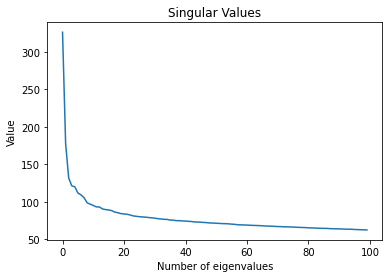

In [28]:
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

u, s, vt = svds(sparse_array, 100, which= 'LM')

plt.title('Singular Values')
plt.ylabel('Value')
plt.xlabel('Number of eigenvalues')
plt.plot(s[::-1])
plt.show()

### Calculate predictions for each k

In [30]:
from scipy.sparse.linalg import svds

svd_predictions =[]
k_values = [1,5,10,20,30,40,50,75,100]

start = time.time()
for k in k_values:
    u_k, s_k, vt_k = svds(sparse_array, k, which= 'LM')
    s_k = np.diag(s_k)

    for k in range(k, 0, -1):
        Rk_aprrox = u_k[:, k:].dot(s_k[k:, k:]).dot(vt_k[k:,:])
    Rk_aprrox = u_k.dot(s_k).dot(vt_k)
    Rk_aprrox = np.where(Rk_aprrox < 0, 0, Rk_aprrox)
    Rk_aprrox = np.where(Rk_aprrox > 5, 5, Rk_aprrox)
    svd_predictions.append(Rk_aprrox)

svd_predictions = np.array(svd_predictions)

svd_pred = []
for i in range(svd_predictions.shape[0]):
    temp_preds = []
    for j in range(len(sample_array)):
        temp_preds.append(svd_predictions[i][find_index(sample_array[j][0])][find_business(sample_array[j][1])])
    svd_pred.append(temp_preds)

svd_predictions = np.array(svd_pred)

stop = time.time()
print("SVD predictions for all given k values in {:.3f} mins".format((stop-start)/60))

SVD predictions for all given k values in 1.585 mins


# Step 6

In [31]:
true_ratings = sample_data['rating'].values.astype(float).astype(int)

############################
# RMSE FOR UCF
RMSE_UCF = []
for i in range(ucf_predictions[0].size):
    predicted_ratings = np.array(ucf_predictions[:,i])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_UCF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    
############################
# RMSE FOR ICF
RMSE_ICF = []
for i in range(icf_predictions[0].size):
    predicted_ratings = np.array(icf_predictions[:,i])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_ICF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    
    
############################
# RMSE FOR MODIFIED UCF
for i in range(ucf2_predictions.shape[0]):
    for j in range(ucf2_predictions.shape[1]):
        if ucf2_predictions[i][j]<0:
            ucf2_predictions[i][j] = 0
        if ucf2_predictions[i][j]>5:
            ucf2_predictions[i][j] = 5

RMSE_UCF2 = []
for i in range(ucf2_predictions[0].size):
    predicted_ratings = np.array(ucf2_predictions[:,i])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_UCF2.append(math.sqrt(sum_of_difference/sample_data.shape[0]))


############################
# RMSE FOR SVD
RMSE_SVD = []
for i in range(svd_predictions.shape[0]):
    predicted_ratings = np.array(svd_predictions[i,:])
    sum_of_difference = 0
    for j in range(sample_data.shape[0]):
        sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
    RMSE_SVD.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    
    
############################
# RMSE FOR USER AVERAGE
sum_of_difference = 0
for i in range(sample_data.shape[0]):
    sum_of_difference += (user_avg_pred[i] - true_ratings[i])**2
RMSE_UA = math.sqrt(sum_of_difference/sample_data.shape[0])


############################
# RMSE FOR BUSINESS AVERAGE
sum_of_difference = 0
for i in range(sample_data.shape[0]):
    sum_of_difference += (business_avg_pred[i] - true_ratings[i])**2
RMSE_ΒΑ = math.sqrt(sum_of_difference/sample_data.shape[0])

In [36]:
results = []
results.append([min(RMSE_UCF2), 'RMSE_UCF2'])
results.append([min(RMSE_UCF), 'RMSE_UCF'])
results.append([min(RMSE_ICF), 'RMSE_ICF'])
results.append([min(RMSE_SVD), 'RMSE_SVD'])
results.append([RMSE_ΒΑ, 'RMSE_BA'])
results.append([RMSE_UA, 'RMSE_UA'])

results = sorted(results, key=itemgetter(0))
results

[[0.9889004698325338, 'RMSE_UCF2'],
 [0.996927790727206, 'RMSE_BA'],
 [1.0039482142184168, 'RMSE_UCF'],
 [1.0238300442069046, 'RMSE_ICF'],
 [1.0251526611296322, 'RMSE_UA'],
 [3.580597714206923, 'RMSE_SVD']]

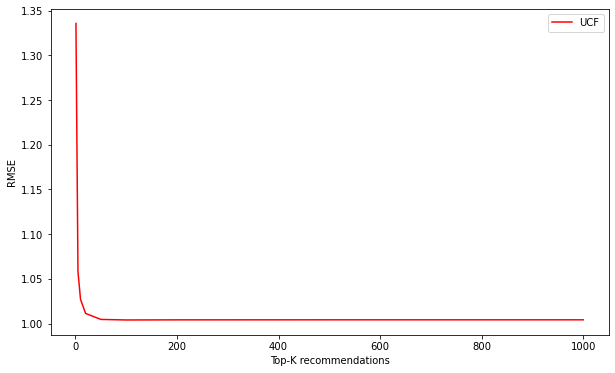

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x = [1,5,10,20,50,100,200,500,1000]
plt.plot(x, RMSE_UCF, "r", label = "UCF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

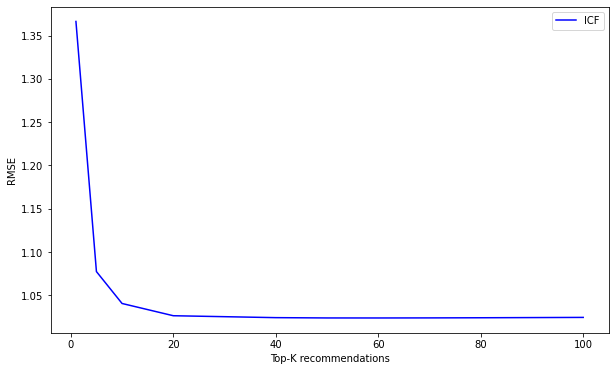

In [45]:
plt.figure(figsize=(10, 6))
x = [1,5,10,20,40,50,60,70,80,100]
plt.plot(x, RMSE_ICF, "b", label = "ICF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

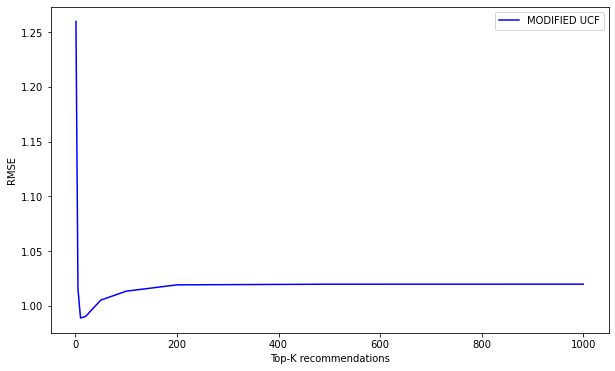

In [46]:
plt.figure(figsize=(10, 6))
x = [1,5,10,20,50,100,200,500,1000]
plt.plot(x, RMSE_UCF2, "b", label = "MODIFIED UCF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

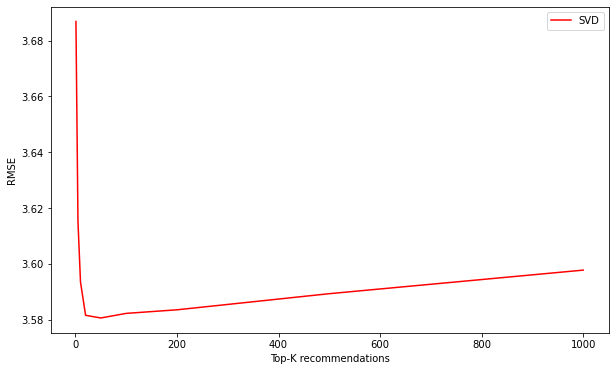

In [47]:
plt.figure(figsize=(10, 6))
k_values = [1,5,10,20,30,40,50,75,100]
plt.plot(x, RMSE_SVD, "r", label = "SVD")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

Παρατηρούμε ότι η καλύτερη μέθοδος είναι αναμενόμενα η παραλλαγή της UCF καθώς προβλέπει τις αποκλίσεις από την μέση τιμή, ενώ ακολουθούν με τη σειρά οι BA(Business Average), UCF, ICF, UA(User Average), SVD. Έκπληξη αποτελούν οι μέθοδοι Business Average και User Average καθώς είναι και οι πιο απλοί στην υλοποίηση τους. Επίσης το SVD δεν αποτελεί έκπληξη που είναι η χειρότερη μέθοδος καθώς είναι δύσκολο να γίνει επιλογή των σημαντικότερων πινάκων για την επανακατασκευή του αραιού πίνακα.